In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!wget 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'

--2025-10-08 17:29:26--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv.1’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.02s   

2025-10-08 17:29:26 (37.3 MB/s) - ‘car_fuel_efficiency.csv.1’ saved [874188/874188]



In [2]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [3]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
# going to filter this down to a subset of columns for the homework
df = df[['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']]
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


## EDA
*Does fuel efficiency have a long tail?*  **No, it appears the data is normally distributed**

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

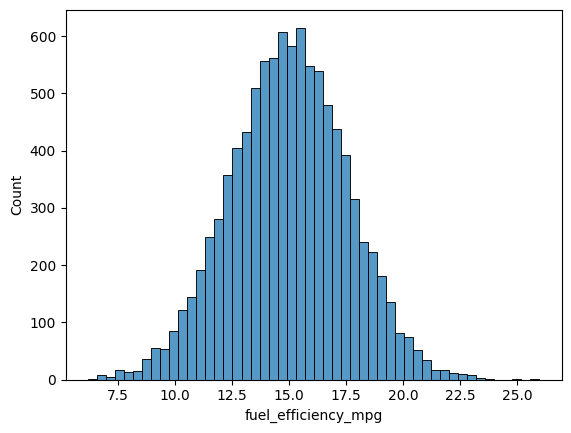

In [5]:
sns.histplot(df.fuel_efficiency_mpg,bins=50)

## Question1 
*There is one column with missing values.  Which is it?* **Horsepower**

In [6]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

## Question 2
*What is the median (50%) for 'horsepower'?* **149**

In [7]:
df.horsepower.median()

np.float64(149.0)

In [8]:
# Additional data preparation. Create train/validation/test sets, shuffle (use seed 42)

# First, creating randomized index that will be used to shape the dataset
idx = np.arange(len(df))
np.random.seed(42)
np.random.shuffle(idx)

# Next, splitting the data 
n = len(df)
n_val = int(n*.2)
n_test = int(n*.2)
n_train = n - n_val - n_test

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

print (n_train, len(df_train))
print (n_val, len(df_val))
print (n_test, len(df_test))

df_train.head()

5824 5824
1940 1940
1940 1940


,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
483,220,144.0,2535.887591,2009,16.642943
7506,160,141.0,2741.170484,2019,16.298377
8795,230,155.0,2471.880237,2017,18.591822
1688,150,206.0,3748.164469,2015,11.818843
6217,300,111.0,2135.716359,2006,19.402209


In [12]:
# remember to split out your target data
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

## Question 3
*What is the best method to fill in missing values?* **Using the mean**

In [33]:
# need to build models filling in missing data with zeros and the mean and determine best approach
X_train_zeros = df_train.fillna(0).values
X_train_mean = df_train.fillna(df_train['horsepower'].mean()).values

X_val_zeros = df_val.fillna(0).values
X_val_mean = df_val.fillna(df_train['horsepower'].mean()).values  #note that we're using the mean from the training dataset

In [31]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [34]:
w0_zeros, w_zeros = train_linear_regression(X_train_zeros, y_train)
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)

In [43]:
#now we use the two models to compare
y_pred_zeros = w0_zeros + X_val_zeros.dot(w_zeros)
y_pred_mean = w0_mean + X_val_mean.dot(w_mean)

#and of course show the RMSE
print (round(rmse(y_val, y_pred_zeros),2), round(rmse(y_val, y_pred_mean),2))

0.52 0.46


*In this case, the approach using the mean is better.  Likely since it maintains a more central approach, vs. introducing likely negative bias*

## Q4 - Best results of tuned model with regularized model

*Which value of 'r' is best?'* **Rounding to 2 digits wasn't enough, all were equal.  Rounding to 4 indicates r=0.01 is best**

In [38]:
#now that we're focused on replacing NaN's with zeros, instituting the repeatable function wrapper

def prepare_X(df):
    df_num = df.copy()      
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [39]:
def train_linear_regression_reg (X, y, r=0.001):
    ones = np.ones(X.shape[0]) 
    X = np.column_stack([ones,X])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [45]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = round(rmse(y_val, y_pred),4)
    print(r, w0, score)

0 28.82736547365895 0.5174
0.01 24.92683841981215 0.5171
0.1 11.239661084581073 0.5188
1 1.7315979411219746 0.5222
5 0.3638075020482907 0.5229
10 0.18306246621686947 0.523
100 0.01841801730688404 0.5231


## Q5 - Experimenting with Different Seed Values
*What is the std deviation of the scores?* **Std Dev is .006**


In [65]:
score_list = []
idx = np.arange(n)
for s in range(10):
    np.random.seed(s)
    np.random.shuffle(idx)
    
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    y_train = df_train.fuel_efficiency_mpg.values
    y_val = df_val.fuel_efficiency_mpg.values
    y_test = df_test.fuel_efficiency_mpg.values

    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']

    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = round(rmse(y_val, y_pred), 4)
    score_list.append(score)
    print (s, w0, score)
print("Std Dev of scores is: ", round(np.std(score_list),3))

0 27.376388746528697 0.5207
1 28.840131239117106 0.5228
2 29.248718974870677 0.5168
3 28.60658327072845 0.5257
4 25.52021081090735 0.5214
5 28.928065485712366 0.5251
6 28.028014839754697 0.5256
7 27.234948471548357 0.5068
8 28.496373283292634 0.5201
9 27.242367018537344 0.5141
Std Dev of scores is:  0.006


## Q6.  Specific model training results
* What is the RMSE against the training dataset?* **It is 0.515**

In [68]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

df_train_full = pd.concat([df_train, df_val])
df_train_full = df_train_full.reset_index(drop = True)
y_train_full = np.concatenate([y_train, y_val])

X_train_full = prepare_X(df_train_full)
w0, w = train_linear_regression_reg(X_train_full, y_train_full, r=0.001)
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
score = round(rmse(y_test, y_pred), 4)

print (w0, score)

26.946834792836274 0.5156


<Axes: ylabel='Count'>

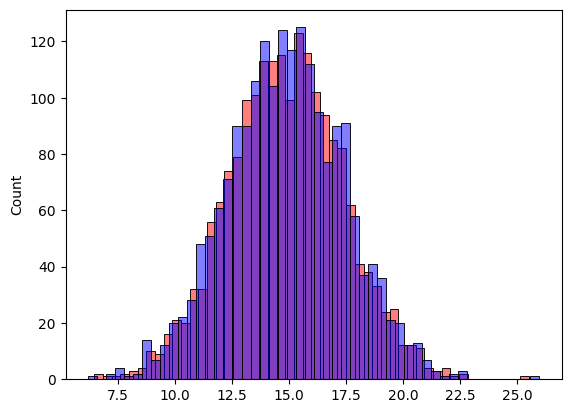

In [69]:
sns.histplot(y_pred, color = 'red', alpha=0.5, bins = 50)
sns.histplot(y_test, color = 'blue', alpha=0.5, bins=50)